In [1]:
import pandas as pd
import h5py
#import umap
import matplotlib.pyplot as plt
from sklearn import svm
import h5py
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

/home/rassh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Hog Features

In [2]:
h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

features_d = h5f_data['dataset_1']
labels_d = h5f_label['dataset_1']

features = np.array(features_d)
labels = np.array(labels_d)

h5f_data.close()
h5f_label.close()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features),
                                                    np.array(labels),
                                                    test_size=.10,random_state=30)

In [7]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(288, 62500) (33, 62500)
(288,) (33,)


## Reduce Features

In [8]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [9]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [10]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (288, 106)
recovered shape: (288, 62500)


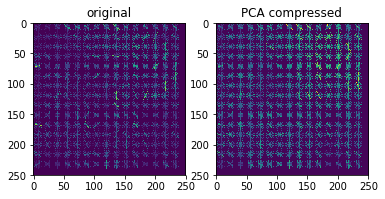

In [11]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((250,250)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((250,250)))
plt.show(block=True)

In [12]:
lbsvm = svm.NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [13]:
lbsvm.fit(X_reduced, y_train)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [14]:
#print(y_train.shape)
#print ("Train labels: {}".format(y_train.shape))

In [15]:
X_test_reduced = pca.transform(X_test)

y_hat_reduced = lbsvm.predict(X_test_reduced)

print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))


accuracy: 0.6666666666666666


In [16]:
param_grid = { 'gamma': [1,0.1,0.01,0.001]} 

In [17]:
grid = GridSearchCV(svm.NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=True),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] gamma=1 .........................................................
[LibSVM][CV] ............................... gamma=1, score=0.5, total=   6.3s
[CV] gamma=1 .........................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ............... gamma=1, score=0.42105263157894735, total=   6.0s
[CV] gamma=1 .........................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s


[CV] ................ gamma=1, score=0.4631578947368421, total=   5.8s
[CV] gamma=0.1 .......................................................
[LibSVM][CV] .............. gamma=0.1, score=0.5918367346938775, total=   5.9s
[CV] gamma=0.1 .......................................................
[LibSVM][CV] .............. gamma=0.1, score=0.5052631578947369, total=   5.9s
[CV] gamma=0.1 .......................................................
[LibSVM][CV] .............. gamma=0.1, score=0.5052631578947369, total=   5.9s
[CV] gamma=0.01 ......................................................
[LibSVM][CV] ............. gamma=0.01, score=0.5918367346938775, total=   5.9s
[CV] gamma=0.01 ......................................................
[LibSVM][CV] ............. gamma=0.01, score=0.5789473684210527, total=   5.6s
[CV] gamma=0.01 ......................................................
[LibSVM][CV] ............ gamma=0.01, score=0.45263157894736844, total=   6.0s
[CV] gamma=0.001 ............

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [18]:
grid_predictions = grid.predict(X_test)

In [19]:
print(confusion_matrix(y_test,grid_predictions))

[[9 5 2]
 [2 7 1]
 [1 0 6]]


In [20]:
print(classification_report(y_test,grid_predictions))

             precision    recall  f1-score   support

          0       0.75      0.56      0.64        16
          1       0.58      0.70      0.64        10
          2       0.67      0.86      0.75         7

avg / total       0.68      0.67      0.66        33

